In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

NOTEBOOK_PATH = Path("/home/venatio/documents/projects/prosperity-imc-2025/src/subs/round_2")
DATA_PATH = NOTEBOOK_PATH / "data"

# Load data
def load_data(day):
    prices = pd.read_csv(DATA_PATH / f"prices_round_2_day_{day}.csv", sep=';')
    trades = pd.read_csv(DATA_PATH / f"trades_round_2_day_{day}.csv", sep=';')
    return prices, trades

# Combine data from all days
all_prices = []
all_trades = []
for day in [-1, 0, 1]:
    prices, trades = load_data(day)
    prices['day'] = day
    trades['day'] = day
    all_prices.append(prices)
    all_trades.append(trades)

prices_df = pd.concat(all_prices)
trades_df = pd.concat(all_trades)

# Preprocess data
def preprocess_data(prices_df):
    # Get mid prices at each timestamp
    mid_prices = prices_df.pivot_table(index=['day', 'timestamp'], columns='product', values='mid_price')
    return mid_prices

mid_prices = preprocess_data(prices_df)

# Backtesting engine
class Backtester:
    def __init__(self, mid_prices):
        self.mid_prices = mid_prices
        self.components = ['CROISSANTS', 'JAMS', 'DJEMBES']
        self.basket = 'PICNIC_BASKET1'

    def calculate_diff(self, row):
        return row[self.basket] - 6*row['CROISSANTS'] - 3*row['JAMS'] - row['DJEMBES']

    def backtest(self, symbol, long_threshold, short_threshold, position_limit=20):
        # Calculate spread
        df = self.mid_prices.copy()
        df['diff'] = df.apply(self.calculate_diff, axis=1)

        # Initialize positions and PnL
        positions = {product: 0 for product in [self.basket] + self.components}
        pnl = 0
        trade_log = []

        for i, (idx, row) in enumerate(df.iterrows()):
            current_diff = row['diff']

            # Check trading signals
            if current_diff < long_threshold and positions[symbol] < position_limit:
                # Go long the basket and short components
                trade_size = min(position_limit - positions[symbol], position_limit)

                # Execute trades at current mid prices
                basket_price = row[self.basket]
                component_prices = {c: row[c] for c in self.components}

                # Update positions and PnL (simplified - no transaction costs)
                positions[self.basket] += trade_size
                positions['CROISSANTS'] -= 6 * trade_size
                positions['JAMS'] -= 3 * trade_size
                positions['DJEMBES'] -= 1 * trade_size

                trade_log.append({
                    'day': idx[0],
                    'timestamp': idx[1],
                    'symbol': symbol,
                    'action': 'long',
                    'size': trade_size,
                    'diff': current_diff,
                    'basket_price': basket_price,
                    'component_prices': component_prices
                })

            elif current_diff > short_threshold and positions[symbol] > -position_limit:
                # Go short the basket and long components
                trade_size = min(positions[symbol] + position_limit, position_limit)

                # Execute trades at current mid prices
                basket_price = row[self.basket]
                component_prices = {c: row[c] for c in self.components}

                # Update positions and PnL
                positions[self.basket] -= trade_size
                positions['CROISSANTS'] += 6 * trade_size
                positions['JAMS'] += 3 * trade_size
                positions['DJEMBES'] += 1 * trade_size

                trade_log.append({
                    'day': idx[0],
                    'timestamp': idx[1],
                    'symbol': symbol,
                    'action': 'short',
                    'size': trade_size,
                    'diff': current_diff,
                    'basket_price': basket_price,
                    'component_prices': component_prices
                })

            # Calculate PnL from price changes (mark-to-market)
            if i > 0:
                prev_row = df.iloc[i-1]
                price_changes = {
                    product: (row[product] - prev_row[product]) * positions[product]
                    for product in [self.basket] + self.components
                }
                pnl += sum(price_changes.values())

        # Final PnL when closing all positions at last prices
        last_prices = df.iloc[-1]
        for product in [self.basket] + self.components:
            pnl += positions[product] * last_prices[product]

        return pnl, pd.DataFrame(trade_log)

In [15]:
# Grid search parameters
def run_grid_search():
    backtester = Backtester(mid_prices)

    # Define parameter ranges
    long_thresholds = np.linspace(100, 400, 10)
    short_thresholds = np.linspace(300, 500, 10)

    # Products to test
    products = ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1']

    results = []

    for product in tqdm(products, desc='Products'):
        for long_thresh in tqdm(long_thresholds, desc=f'Long thresholds for {product}', leave=False):
            for short_thresh in tqdm(short_thresholds, desc=f'Short thresholds for {product}', leave=False):
                if short_thresh <= long_thresh:
                    continue  # Skip invalid combinations

                pnl, _ = backtester.backtest(product, long_thresh, short_thresh)
                results.append({
                    'product': product,
                    'long_threshold': long_thresh,
                    'short_threshold': short_thresh,
                    'pnl': pnl
                })

    return pd.DataFrame(results)

# Run grid search
results_df = run_grid_search()

# Find best parameters
best_params = results_df.loc[results_df.groupby('product')['pnl'].idxmax()]
print("Best parameters:")
print(best_params[['product', 'long_threshold', 'short_threshold', 'pnl']])

Long thresholds for CROISSANTS:   0%|          | 0/10 [00:00<?, ?it/s]

Short thresholds for CROISSANTS:   0%|          | 0/10 [00:00<?, ?it/s]

Short thresholds for CROISSANTS:  10%|█         | 1/10 [00:04<00:36,  4.01s/it]

Short thresholds for CROISSANTS:  20%|██        | 2/10 [00:07<00:31,  3.98s/it]

Short thresholds for CROISSANTS:  30%|███       | 3/10 [00:11<00:27,  3.86s/it]

Short thresholds for CROISSANTS:  40%|████      | 4/10 [00:15<00:23,  3.84s/it]

Short thresholds for CROISSANTS:  50%|█████     | 5/10 [00:19<00:19,  3.80s/it]

Short thresholds for CROISSANTS:  60%|██████    | 6/10 [00:23<00:15,  3.81s/it]

Short thresholds for CROISSANTS:  70%|███████   | 7/10 [00:26<00:11,  3.78s/it]

Short thresholds for CROISSANTS:  80%|████████  | 8/10 [00:30<00:07,  3.80s/it]

Short thresholds for CROISSANTS:  90%|█████████ | 9/10 [00:34<00:03,  3.78s/it]

Short thresholds for CROISSANTS: 100%|██████████| 10/10 [00:38<00:00,  3.80s/it]

                                            

Best parameters:
            product  long_threshold  short_threshold          pnl
50       CROISSANTS      266.666667            300.0  138745340.0
226         DJEMBES      266.666667            300.0  138745340.0
138            JAMS      266.666667            300.0  138745340.0
264  PICNIC_BASKET1      100.000000            300.0       5600.0


In [19]:
product_results = []

for _, row in results_df.iterrows():
    for product in ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1']:
        product_results.append({
            'product': product,
            'long_threshold': row['long_threshold'],
            'short_threshold': row['short_threshold'],
            'pnl': row['pnl'],  # Or use product-specific PnL if available
        })

product_results_df = pd.DataFrame(product_results)

In [20]:
# Now the corrected visualization function
def plot_results(product):
    product_data = product_results_df[product_results_df['product'] == product]

    plt.figure(figsize=(12, 8))

    # Correct pivot syntax for newer pandas versions
    pivot_table = product_data.pivot_table(
        index='long_threshold',
        columns='short_threshold',
        values='pnl',
        aggfunc='mean'  # In case there are duplicate entries
    )

    sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='coolwarm')
    plt.title(f'PnL Heatmap for {product}')
    plt.xlabel('Short Threshold')
    plt.ylabel('Long Threshold')
    plt.show()

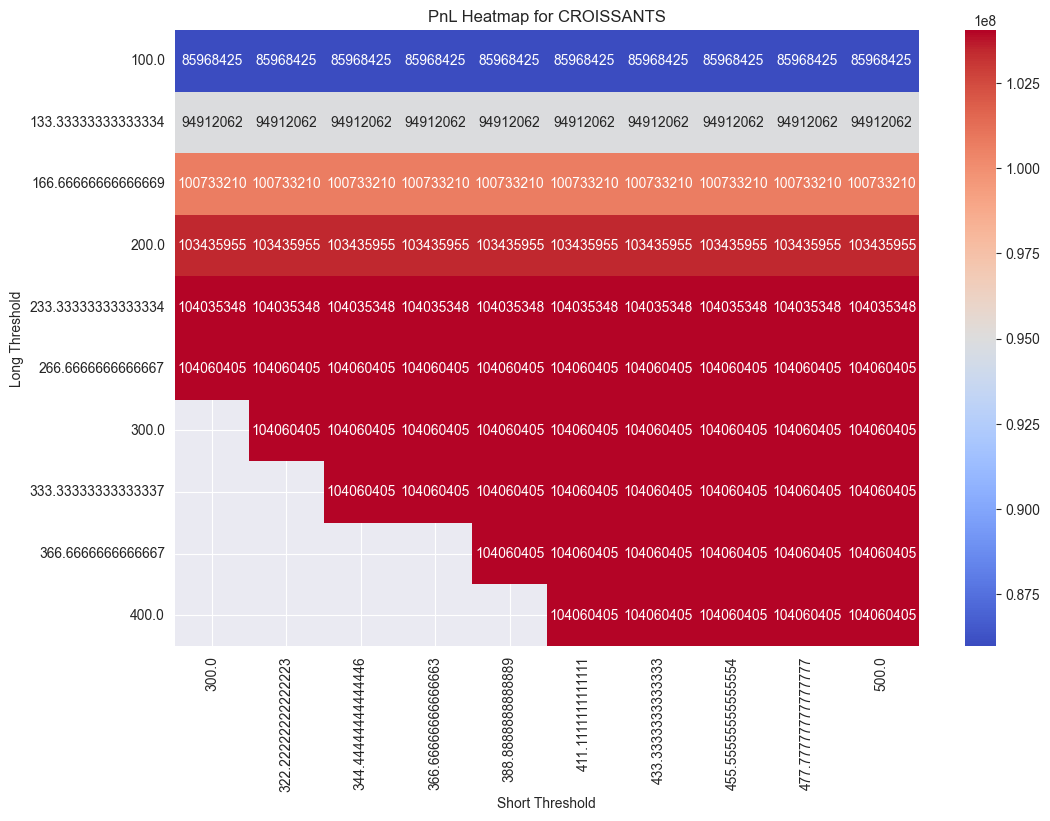

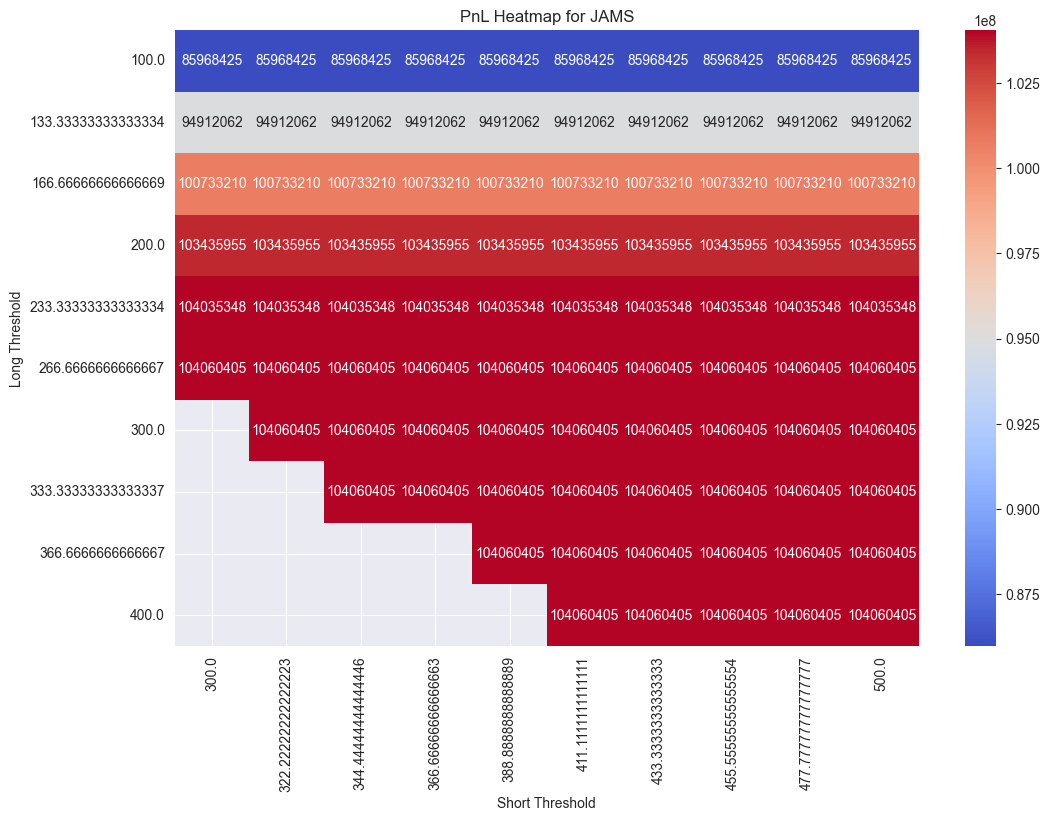

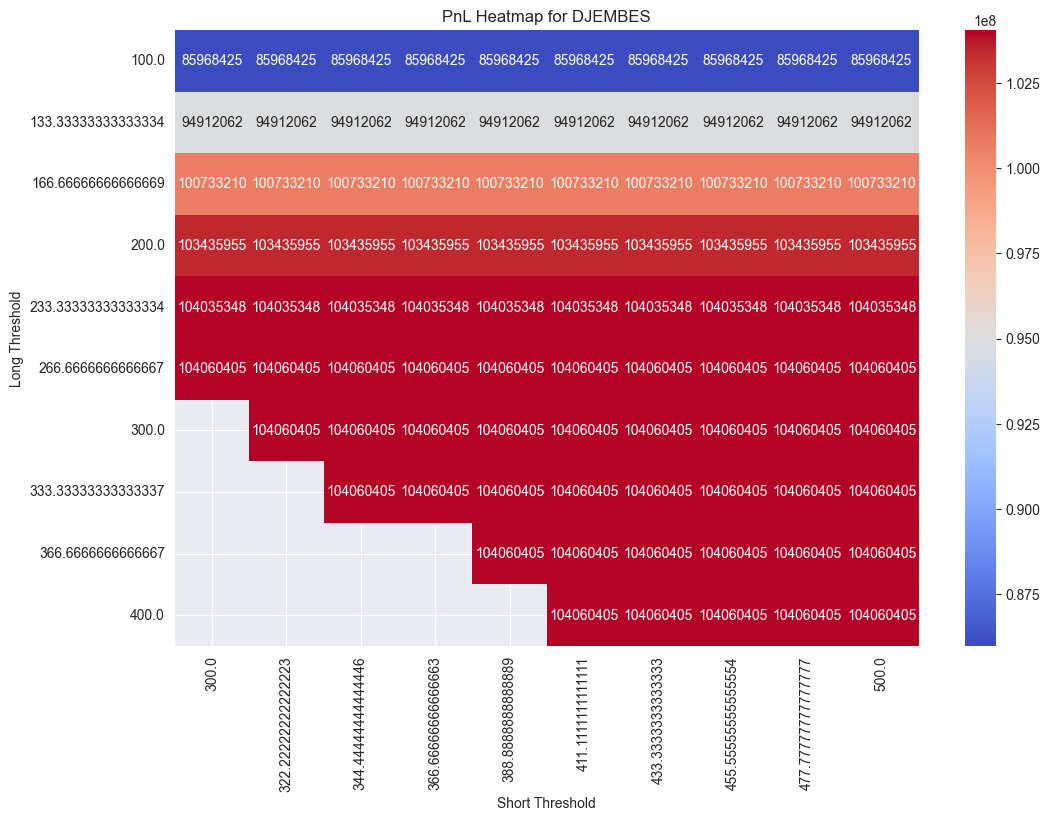

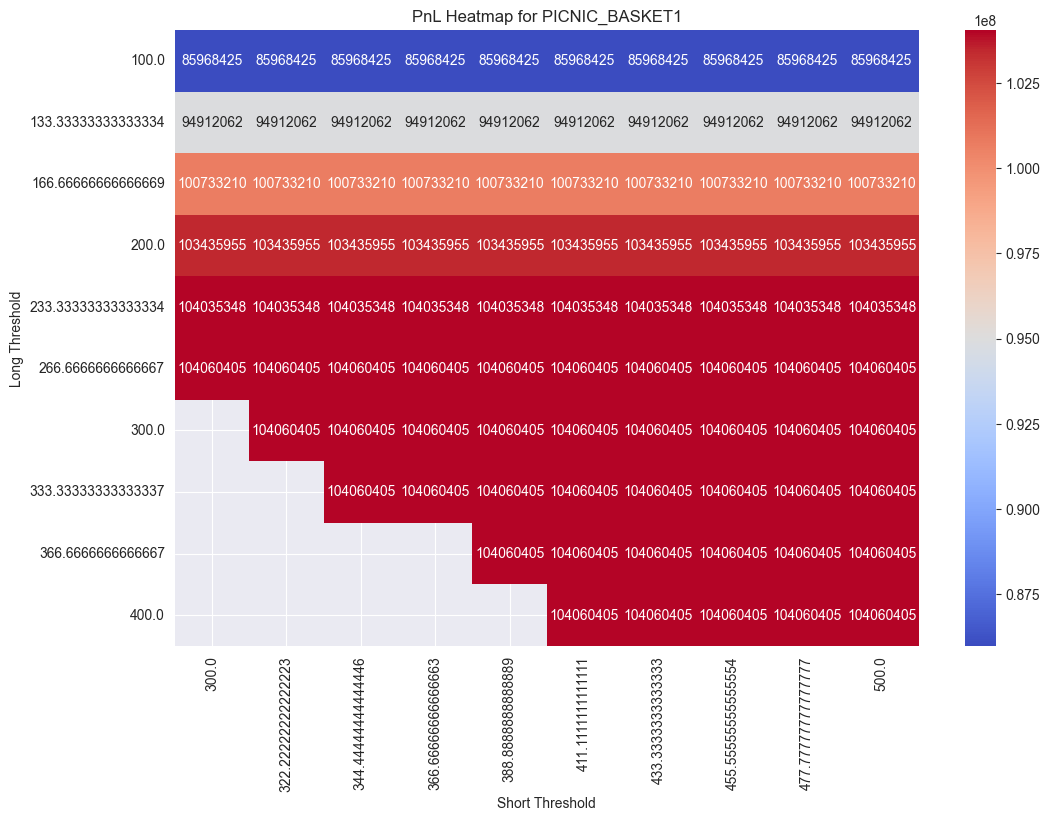

In [21]:
# Generate plots for each product
for product in ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1']:
    plot_results(product)

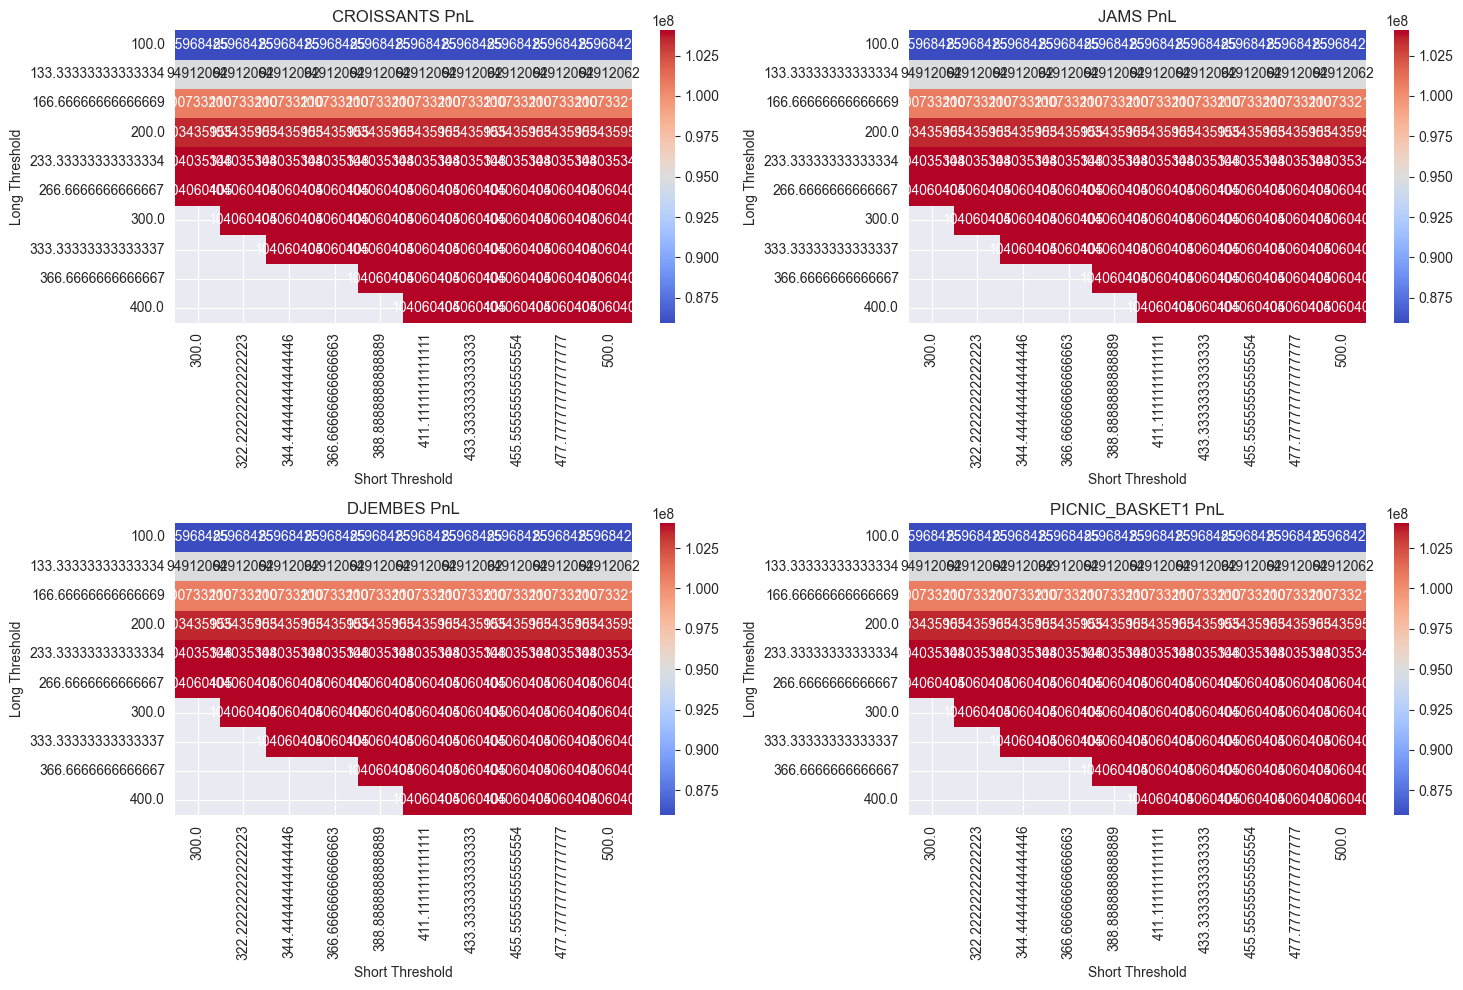

In [22]:
# Alternative visualization showing all products in one figure
plt.figure(figsize=(15, 10))
for i, product in enumerate(['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1'], 1):
    plt.subplot(2, 2, i)
    product_data = product_results_df[product_results_df['product'] == product]
    pivot_table = product_data.pivot_table(
        index='long_threshold',
        columns='short_threshold',
        values='pnl',
        aggfunc='mean'
    )
    sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='coolwarm')
    plt.title(f'{product} PnL')
    plt.xlabel('Short Threshold')
    plt.ylabel('Long Threshold')
plt.tight_layout()
plt.show()